Imports for model cnn with 12 layers 

In [ ]:

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.layers import  PReLU
from keras.layers.convolutional import ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import AveragePooling2D
from keras.models import Sequentialﬁ
from keras.optimizers import Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!unzip /content/drive/MyDrive/imgs.zip


In [ ]:

"""
This file contains project global parameters.


"""
import os
from PIL import ImageFont

# W = Space
# X = Del
# Y = None
classes = 'A B C D E F G H I J K L M N O P Q R S T U V W X Y'.split()

alphaBet = "א ב ג ד ה ו ז ח ט י כ ל מ נ ס ע פ צ ק ר ש ת".split()  # use this and not 'א'+index since includes finals.
alphaBet.append(' ')  # append space to be at the last index.
# finals: ך ם ן ף ץ
# Define a dictionary that maps Hebrew alphabet characters to their English counterparts

modelPath = '/content/drive/MyDrive/finals/Model/cnn12_model.h5'
modelWeights = '/content/drive/MyDrive/finals/Model/trainWeights.h5'

font = ImageFont.truetype(font='/content/drive/MyDrive/finals/fonts/arial.ttf', size=32)

# Image Dimension
imgDim = 128

# HyperParams
nbatch = 128  # 32 default. Number of samples to propagate each epoch.
learnRate = 0.001

# Dataset folders
trainFolder = '/content/images/train/'
validFolder = '/content/images/validation/'
testFolder = '/content/images/test/'

# Log folder to save weights and training graphs.
logFolder = "/content/Temp"
try:
    os.makedirs(logFolder)
except OSError:
    pass


OSError: ignored

In [ ]:
def add_block(block_index, model):
    """
    Adds a block of convolutional layers to the given model.

    :param block_index: the index of the block to add.
    :param model: the model to add the block to.
    :return: the updated model.
    """
    # Add first convolutional layer
    model.add(Conv2D(32 * block_index, (3, 3), input_shape=(imgDim, imgDim, 1)))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(BatchNormalization())
    model.add(PReLU())

    # Add second convolutional layer
    model.add(Conv2D(32 * block_index, (3, 3)))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(BatchNormalization())
    model.add(PReLU())

    # Add max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))

    return model
    
def add_last_block(model):
    """
    Adds the last block of convolutional layers and fully connected layers to the given model.

    :param model: the model to add the block to.
    :return: the updated model.
    """
    # Add first convolutional layer
    model.add(Conv2D(1028, (3, 3)))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(BatchNormalization())
    model.add(PReLU())

    # Add second convolutional layer
    model.add(Conv2D(1028, (3, 3)))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(BatchNormalization())
    model.add(PReLU())

    # Add average pooling layer
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Add first fully connected layer
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))

    # Add output layer
    model.add(Dense(len(classes), activation='softmax'))

    return model

In [ ]:
def getModel(weightsPath=modelWeights,num_of_blocks=6):
    """
    Build cnn12 model and load pre-trained weights if provided.

    :param weightsPath: pre-trained weights h5 file.
    :return: compiled cnn12 model.
    """
    model = Sequential()
    for block_index in range(0,num_of_blocks):
      model= add_block(block_index,model)
    model = add_last_block(model)
    # opt = SGD(lr=learnRate, decay=1e-6, momentum=0.9, nesterov=True)
    opt = Adam(lr=learnRate)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    if weightsPath:
        try:
            model.load_weights(weightsPath)
            print("cnn12 weights loaded.")
        except OSError:
            print("Failed loading cnn12 weights!")
    else:
        print("cnn12 weights are not provided.")

    return model


Train Model

In [ ]:
import keras
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [ ]:

# Training Params.
trainWeights = 'trainWeights.h5'  # weights to save
epochs = 35

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    """
    Custom callback class in order to save weights after each epoch.
    Was used to backup weights via Google colab Machine.
    """

    def on_epoch_end(self, epoch, logs=None):
        try:
            copyfile(trainWeights, "Temp/epoch" + str(epoch) + "_weights.h5")
        except OSError:
            pass
        return

In [ ]:
def trainModel():
    """
    Train the CNN12 model by Loading Training and Validation data.
    At the end of the training a learning graph will be plotted.
    """

    # Load training data with augmentation.
    train_datagen = ImageDataGenerator(rescale=1. / 255.,
                                       # randomly rotate up to 40 degrees.
                                       rotation_range=10,
                                       # randomly shift range.
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       fill_mode="nearest")  # fill new pixels created by shift

    train_generator = train_datagen.flow_from_directory(trainFolder,
                                                        target_size=(
                                                            imgDim, imgDim),
                                                        color_mode='grayscale',
                                                        batch_size=nbatch,
                                                        classes=classes,
                                                        class_mode="categorical")

    # # Load validation data (10% of original train data).

    valid_datagen = ImageDataGenerator(rescale=1. / 255.)

    valid_generator = valid_datagen.flow_from_directory(validFolder,
                                                        target_size=(
                                                            imgDim, imgDim),
                                                        color_mode='grayscale',
                                                        batch_size=nbatch,
                                                        classes=classes,
                                                        class_mode="categorical")

    model = getModel()  # Build cnn12 model.
    model.save(modelPath)
    model.summary()

    step_size_train = train_generator.n // train_generator.batch_size
    step_size_test = valid_generator.n // valid_generator.batch_size

    csv_logger = CSVLogger(logFolder + '/training.csv')

    ccb = CustomCallback()
    callbacks_list = [
        ModelCheckpoint(filepath=trainWeights, monitor='val_acc'),
        ccb,
        csv_logger
    ]

    history = model.fit(
        train_generator,
        steps_per_epoch=step_size_train,
        epochs=epochs,
        validation_data=valid_generator,
        validation_steps=step_size_test,
        callbacks=callbacks_list)

    # save weights
    model.save_weights(trainWeights)

  # Plot train graphs
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    nepochs = len(history.history['loss'])
    plt.plot(range(nepochs), history.history['loss'], 'r-', label='train')
    plt.plot(range(nepochs),
             history.history['val_loss'], 'b-', label='validation')
    plt.legend(prop={'size': epochs})
    plt.ylabel('loss')
    plt.xlabel('# of epochs')
    plt.subplot(1, 2, 2)
    plt.plot(range(nepochs), history.history['acc'], 'r-', label='train')
    plt.plot(range(nepochs),
             history.history['val_acc'], 'b-', label='validation')
    plt.legend(prop={'size': epochs})
    plt.ylabel('accuracy')
    plt.xlabel('# of epochs')
    plt.savefig(logFolder + '/graph.png')


In [ ]:
    trainModel()


Test the model

In [ ]:

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import sys
import os


Loading Model and Weights..
Loading test data..
Found 33197 images belonging to 25 classes.
Batch Progress: 100%
Predicting..
512/512 [==============================] - 22s 42ms/step
Testing Accuracy = 99.90%


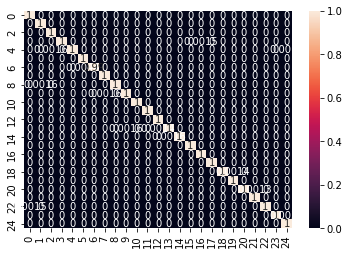

In [ ]:
# Evaluation params
size = nbatch  # Maximum Test Batch size.


print("\nLoading Model and Weights..")
model = load_model(modelPath)
model.load_weights(modelWeights)

# Test Data (20%).
print("Loading test data..")
test_datagen = ImageDataGenerator(rescale=1. / 255.,
                                  rotation_range=10,  # randomly rotate up to 40 degrees.
                                  width_shift_range=0.2,  # randomly shift range.
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  fill_mode="nearest")  # fill new pixels created by shift

test_generator = test_datagen.flow_from_directory(testFolder,
                                                  target_size=(imgDim, imgDim),
                                                  color_mode='grayscale',
                                                  batch_size=nbatch,
                                                  classes=classes,
                                                  class_mode="categorical")
count = 1
x_test, y_test = [], []
for ibatch, (x, y) in enumerate(test_generator):
    sys.stdout.write("\rBatch Progress: %d%%" % (count * 100 / size))
    sys.stdout.flush()
    count += 1
    x_test.append(x)
    y_test.append(y)
    ibatch += 1
    if ibatch == size:
        break

# Concatenate everything together
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)
y_test = np.int32([np.argmax(r) for r in y_test])

# Get the predictions from the model and calculate the accuracy
print("\nPredicting..")
y_pred = np.int32([np.argmax(r) for r in model.predict(x_test, verbose=1)])

match = (y_test == y_pred)

sumString = 'Testing Accuracy = %.2f%%' % (np.sum(match) * 100 / match.shape[0])
print(sumString)

try:
    text_file = open(logFolder + "/TestAccuracy.txt", "w")
    text_file.write(sumString)
    text_file.close()
except OSError:
    pass

# Confusion matrix

plt.figure()
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)
sn.heatmap(cm, annot=True)
plt.savefig(logFolder + '/confusionMat.png', bbox_inches='tight')


### We tested our models with our test mode gui,here are the results:

In [ ]:
import pandas as pd

In [ ]:
hebrew_to_english = {
    'א': 'A',
    'ב': 'B',
    'ג': 'C',
    'ד': 'D',
    'ה': 'E',
    'ו': 'F',
    'ז': 'G',
    'ח': 'H',
    'ט': 'I',
    'י': 'J',
    'כ': 'K',
    'ל': 'L',
    'מ': 'M',
    'נ': 'N',
    'ס': 'O',
    'ע': 'P',
    'פ': 'Q',
    'צ': 'R',
    'ק': 'S',
    'ר': 'T',
    'ש': 'U',
    'ת': 'V',
    'space': 'W',
    'del': 'X',
    'nothing': 'Y',
}


In [ ]:
#open test csv to pd 
test_df= pd.read_csv('test.csv')
test_df

,time,prediction,right_prediction
0,57:02.3,י,א
1,57:15.5,ו,ו
2,57:25.3,י,י
3,57:31.2,ל,ל
4,57:53.8,ט,א
...,...,...,...
355,2023-04-12 15:05:11.509853,ד,ד
356,2023-04-12 17:28:37.067476,ו,ו
357,2023-04-12 17:34:28.550730,ג,nothing
358,2023-04-12 17:34:40.013874,ה,א


In [ ]:
def check_predictions(test_df=test_df):
  for index, row in test_df.iterrows():
    if row.prediction==row.right_prediction:
      test_df.at[index,'sucsess']=1
    else:
      test_df.at[index,'sucsess']=0
  return test_df

In [ ]:
def calculate_success_percentage(df=test_df):
    """Calculate the percentage of success in a binary column of a pandas DataFrame."""
    
    # calculate the percentage of ones in the binary column
    percentage_of_ones = df['sucsess'].mean() * 100
    
    # return the percentage of success
    return round( percentage_of_ones, 2)

def calculate_success_percentage_for_letter(df=test_df,letter=None):
  if letter != None:
    return  calculate_success_percentage(df[df['right_prediction'] == letter])




In [ ]:
def count_letter(df=test_df,letter=None):
   if letter != None:
     return  (df['right_prediction'] == letter).sum()


In [ ]:
test_df=check_predictions(test_df)
test_df

,time,prediction,right_prediction,sucsess
0,57:02.3,י,א,0.0
1,57:15.5,ו,ו,1.0
2,57:25.3,י,י,1.0
3,57:31.2,ל,ל,1.0
4,57:53.8,ט,א,0.0
...,...,...,...,...
355,2023-04-12 15:05:11.509853,ד,ד,1.0
356,2023-04-12 17:28:37.067476,ו,ו,1.0
357,2023-04-12 17:34:28.550730,ג,nothing,0.0
358,2023-04-12 17:34:40.013874,ה,א,0.0


In [ ]:
calculate_success_percentage(test_df)

62.46

In [ ]:
results_per_letter= [(letter, calculate_success_percentage_for_letter(test_df,letter),count_letter(test_df,letter)) for letter in hebrew_to_english.keys()]
results_per_letter_df = pd.DataFrame(results_per_letter, columns=['letter', 'success rate','letter_counter'])

results_per_letter_df

,letter,success rate,letter_counter
0,א,5.41,37
1,ב,100.00,11
2,ג,66.67,3
3,ד,100.00,17
4,ה,71.43,7
5,ו,72.22,18
6,ז,100.00,4
7,ח,76.47,17
8,ט,93.75,16
9,י,76.67,30


In [ ]:
#fix test file 
def fix_test(test_df=test_df):
  indexes_to_delete=[]
  for index, row in test_df.iterrows():
     if row['prediction']==row['right_prediction']:
       if(test_df.at[index+1,'right_prediction']=='א'):
         indexes_to_delete.append(index+1)
  return test_df.drop(indexes_to_delete)
test_df=fix_test(test_df)

test_df

,time,prediction,right_prediction,sucsess
0,57:02.3,י,א,0.0
1,57:15.5,ו,ו,1.0
2,57:25.3,י,י,1.0
3,57:31.2,ל,ל,1.0
5,58:47.3,ט,ש,0.0
...,...,...,...,...
355,2023-04-12 15:05:11.509853,ד,ד,1.0
356,2023-04-12 17:28:37.067476,ו,ו,1.0
357,2023-04-12 17:34:28.550730,ג,nothing,0.0
358,2023-04-12 17:34:40.013874,ה,א,0.0


In [ ]:
def combine_csv_files(file1_path, file2_path):
    # load the first CSV file into a DataFrame
    df1 = pd.read_csv(file1_path)

    # load the second CSV file into a DataFrame
    df2 = pd.read_csv(file2_path)

    # concatenate the two DataFrames vertically
    combined_df = pd.concat([df1, df2], ignore_index=True)

    return combined_df
test_df=combine_csv_files('/content/test1.csv','/content/test2.csv')

FileNotFoundError: ignored

In [ ]:
test_df.to_csv('test.csv', index=False)